## Interpret data colleccted in data.csv, and run statistics and meaningfull plots

### 1 - Creation of the data file (already done)

In [1]:
import csv
import os

headers = [
    "DateTime", "NumEpochs", "SwitchEpoch", "AlphaForEpochSup140", "Condition", "Digits", "SilhouetteScore", "NMI",
    "acc_0", "acc_1", "acc_2", "acc_3", "acc_4", "acc_5", "acc_6", "acc_7", "acc_8", "acc_9",
    "acc_mean", "SSIM_mean", "x_class_as_y", "y_class_as_x"
]

file_name = 'experiment.csv'

with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    print(f"Created {file_name} with headers.")


Created experiment.csv with headers.


### 2 - Adding values to it (already done during experiments)

In [ ]:
with open('experiment.csv', mode='a', newline='') as data_file:
    writer = csv.writer(data_file)
    writer.writerow([
        datetime.now(),
        num_epochs,
        swap_epoch,
        AlphaForEpochSup140,
        Condition,
        Digits,
        silhouette,
        nmi_score,
        [acc_epoch[0] for acc_epoch in test_acc],
        [acc_epoch[1] for acc_epoch in test_acc],
        [acc_epoch[2] for acc_epoch in test_acc],
        [acc_epoch[3] for acc_epoch in test_acc],
        [acc_epoch[4] for acc_epoch in test_acc],
        [acc_epoch[5] for acc_epoch in test_acc],
        [acc_epoch[6] for acc_epoch in test_acc],
        [acc_epoch[7] for acc_epoch in test_acc],
        [acc_epoch[8] for acc_epoch in test_acc],
        [acc_epoch[9] for acc_epoch in test_acc],
        [statistics.mean(epoch.values()) for epoch in test_acc],  
        test_ssim,
        [class_epoch[0] for class_epoch in tracked_class], # or np.nan if normal condtion
        [class_epoch[1] for class_epoch in tracked_class], # or np.nan if normal condtion
    ])

### 2 - Curating data

In [27]:
import pandas as pd
import numpy as np
import ast

# Function to safely evaluate string as list
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Function to calculate mean of a specific range in a list
def calculate_range_mean(lst, start, end):
    return np.mean(lst[start-1:end]) if len(lst) >= end else np.nan

# Function to trim list to last 251 elements
def trim_list(x, condition):
    if condition == 'Apathy' and len(x) > 251:
        return x[-251:]
    return x

In [28]:
# Load the CSV file
df = pd.read_csv('experiment.csv')

In [29]:
# Convert string representations of lists to actual lists
list_columns = ["SilhouetteScore", "NMI", "acc_0", "acc_1", "acc_2", "acc_3", "acc_4", "acc_5", "acc_6", "acc_7", "acc_8", "acc_9",
    "acc_mean", "SSIM_mean", "x_class_as_y", "y_class_as_x"]
for col in list_columns:
    df[col] = df[col].apply(safe_eval)

In [30]:
# Trim x_class_as_y and y_class_as_x for Apathy condition
df['x_class_as_y'] = df.apply(lambda row: trim_list(row['x_class_as_y'], row['Condition']), axis=1)
df['y_class_as_x'] = df.apply(lambda row: trim_list(row['y_class_as_x'], row['Condition']), axis=1)

In [31]:
# Define the new columns to add and their corresponding base columns
new_columns = {
    'SilhouetteScore': ['SilhouetteScore_132-141', 'SilhouetteScore_142-151', 'SilhouetteScore_242-251'],
    'NMI': ['NMI_132-141', 'NMI_142-151', 'NMI_242-251'],
    'acc_mean': ['acc_mean_132-141', 'acc_mean_142-151', 'acc_mean_242-251'],
    'SSIM_mean': ['SSIM_mean_132-141', 'SSIM_mean_142-151', 'SSIM_mean_242-251'],
    'x_class_as_y': ['x_as_y_132-141', 'x_as_y_142-151', 'x_as_y_242-251'],
    'y_class_as_x': ['y_as_x_132-141', 'y_as_x_142-151', 'y_as_x_242-251']
}

In [32]:
# Add new columns and calculate their values
for base_col, new_cols in new_columns.items():
    for new_col in new_cols:
        start, end = map(int, new_col.split('_')[-1].split('-'))
        df[new_col] = df[base_col].apply(lambda x: calculate_range_mean(x, start, end))

    # Add difference columns
    base_range = new_cols[0].split('_')[-1]
    for compare_col in new_cols[1:]:
        compare_range = compare_col.split('_')[-1]
        diff_col = f"{base_col}_diff_{base_range}_{compare_range}"
        df[diff_col] = df[compare_col] - df[new_cols[0]]

In [33]:
# Reorder columns to place new columns and difference columns after their base column
for base_col, new_cols in new_columns.items():
    insert_index = df.columns.get_loc(base_col) + 1
    cols_to_move = new_cols + [f"{base_col}_diff_{new_cols[0].split('_')[-1]}_{col.split('_')[-1]}" for col in new_cols[1:]]
    for i, col in enumerate(cols_to_move):
        if col in df.columns:  # Check if the column exists
            col_data = df.pop(col)
            df.insert(insert_index + i, col, col_data)

In [34]:
# Save the modified DataFrame back to CSV
df.to_csv('curated_data.csv', index=False)

print("CSV file has been modified and saved as 'curated_data.csv'")

CSV file has been modified and saved as 'curated_data.csv'


### 3 - Stats anaysis on key values

Sort by, and run statistics between the categories:
- Condition: "Normal", "Apathy", "Delusion"
- AlphaForSupEpoch140: 0.2; 0.5; 0.8
- +/- Digits (for Conditions "Apathy" and "Delusion"): see if the Digits as an effect on the results (hypothesis: yes)

Variables to compare:
- 'SilhouetteScore_132-141' to 'SilhouetteScore_142-151' and to 'SilhouetteScore_242-251'
- 'NMI_132-141' to 'NMI_142-151'and to 'NMI_242-251'
- 'acc_mean_132-141' to 'acc_mean_142-151' and to 'acc_mean_242-251'
- 'SSIM_mean_132-141' to 'SSIM_mean_142-151' and to 'SSIM_mean_242-251'
- 'x_as_y_132-141' to 'x_as_y_142-151' and to 'x_as_y_242-251'
- 'y_as_x_132-141' to 'y_as_x_142-151' and to 'y_as_x_242-251'

In [35]:
# Load the modified CSV file
df = pd.read_csv('curated_data.csv')

# Convert 'Digits' column to numeric, replacing any non-numeric values with NaN
df['Digits'] = pd.to_numeric(df['Digits'], errors='coerce')

In [36]:
# Define the categories and variables for comparison
condition_pairs = [("Normal", "Apathy"), ("Normal", "Delusion")]
alpha_values = [0.2, 0.5, 0.8]
variables = ['SilhouetteScore', 'NMI', 'acc_mean', 'SSIM_mean']
variable_spe_condition = ['SilhouetteScore', 'NMI', 'acc_mean', 'SSIM_mean','x_class_as_y', 'y_class_as_x']
ranges = ['132-141', '142-151', '242-251']
digit_groups = [(0, 1), (4, 9), (3, 8)]



In [37]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def check_normality(data):
    _, p_value = stats.shapiro(data)
    return p_value > 0.05  # Returns True if data is likely normal (p > 0.05)

def run_statistical_tests(group1, group2):
    if check_normality(group1) and check_normality(group2):
        t_stat, p_value = stats.ttest_ind(group1, group2)
        test_name = "t-test"
    else:
        t_stat, p_value = stats.mannwhitneyu(group1, group2)
        test_name = "Mann-Whitney U test"
    return p_value, test_name

In [56]:
# Simple test without crossed effects 
def analyze_variable(df, variable, condition_pair):
    normal_condition, other_condition = condition_pair
    print(f"\nAnalysis for {variable}: {normal_condition} vs {other_condition}")
    for alpha in alpha_values:
        print(f"  Alpha = {alpha}:")
        normal_subset = df[(df['Condition'] == normal_condition) & (df['AlphaForEpochSup140'] == alpha)]
        other_subset = df[(df['Condition'] == other_condition) & (df['AlphaForEpochSup140'] == alpha)]
        for range_val in ranges:
            var = f"{variable}_{range_val}"
            p_value, test_name = run_statistical_tests(normal_subset[var], other_subset[var])
            print(f"    {var}: p-value = {p_value:.4f} ({test_name})")
            if p_value < 0.05:
                if normal_subset[var].mean() > other_subset[var].mean():
                    print(f"{normal_condition}: {normal_subset[var].mean()} > {other_condition}: {other_subset[var].mean()}")
                else:
                    print(f"{other_condition}: {other_subset[var].mean()} > {normal_condition}: {normal_subset[var].mean()}")
            else:
                print(f"No significant difference between {normal_condition} and {other_condition} for {var}")



def plot_variable_across_conditions(df, variable, condition_pair):
    normal_condition, other_condition = condition_pair
    plt.figure(figsize=(8, 6))
    for i, range_val in enumerate(ranges):
        var = f"{variable}_{range_val}"
        subset = df[df['Condition'].isin([normal_condition, other_condition])]
        sns.boxplot(x='Condition', y=var, hue='AlphaForEpochSup140', data=subset)
        if variable == 'acc_mean':
            #plt.ylim(65, 100)
            plt.ylabel("Accuracy (%)")
        if variable == 'NMI':
            #plt.ylim(0.4, 1)
            plt.ylabel("NMI")
        plt.title(f"Stats_{var}: {normal_condition} vs {other_condition}")
        if variable == 'SSIM_mean':
            #plt.ylim(-0.2, 0.2)
            plt.ylabel("SSIM")
        plt.savefig(f"./Plots/Stats/{variable}/Stats_{var}_{normal_condition}_vs_{other_condition}_0.png")
        plt.close()


def plot_individual_variable(df, variable, condition_pair, range_val):
    normal_condition, other_condition = condition_pair
    plt.figure(figsize=(8, 6))
    var = f"{variable}_{range_val}"
    subset = df[df['Condition'].isin([normal_condition, other_condition])]
    sns.boxplot(x='Condition', y=var, hue='AlphaForEpochSup140', data=subset)
    if variable == 'acc_mean':
        plt.ylim(65, 100)
        plt.ylabel("Accuracy (%)")
    if variable == 'NMI':
        plt.ylim(0.4, 1)
        plt.ylabel("NMI")
    if variable == 'SSIM_mean':
        plt.ylim(0.1, 0.2)
        plt.ylabel("SSIM")
    plt.title(f"Stats_{var}: {normal_condition} vs {other_condition}")
    plt.savefig(f"./Plots/Stats/{variable}/Stats_{var}_{normal_condition}_vs_{other_condition}_1.png")
    plt.close()


# plot variables across timepoints for alpha == 0.5, for both conditions
def plot_variable_across_timepoints(df, variable, condition_pair, alpha):
    normal_condition, other_condition = condition_pair
    plt.figure(figsize=(12, 6))
    
    subset = df[(df['Condition'].isin([normal_condition, other_condition])) & 
                (df['AlphaForEpochSup140'] == alpha)]
    
    data_to_plot = []
    for condition in [normal_condition, other_condition]:
        for range_val in ['132-141', '142-151', '242-251']:
            var = f"{variable}_{range_val}"
            data = subset[subset['Condition'] == condition][var]
            data_to_plot.append((condition, range_val, data))
    
    positions = np.arange(len(data_to_plot))
    box_width = 0.4
    
    for i, (condition, range_val, data) in enumerate(data_to_plot):
        color = 'lightblue' if condition == normal_condition else 'lightgreen'
        box = plt.boxplot(data, positions=[positions[i]], widths=box_width, 
                          patch_artist=True, boxprops=dict(facecolor=color))
        
        # Add some jitter to the data points
        x = np.random.normal(positions[i], 0.04, size=len(data))
        plt.scatter(x, data, alpha=0.3, s=5, color='black')
    
    plt.xlabel('Timepoints')
    plt.ylabel(variable)
    plt.title(f'Stats_{variable} across Timepoints for alpha post epoch 140 = {alpha} in {normal_condition} vs {other_condition})')
    
    # Set x-ticks and labels
    plt.xticks(positions, ['132-141', '142-151', '242-251'] * 2)
    
    # Add a legend
    plt.legend([plt.Rectangle((0,0),1,1,fc='lightblue'), 
                plt.Rectangle((0,0),1,1,fc='lightgreen')],
               [normal_condition, other_condition], 
               loc='upper right')
    
    # Add vertical lines to separate timepoints
    for x in [1.5, 3.5]:
        plt.axvline(x=x, color='gray', linestyle='--', alpha=0.5)
    if variable == 'acc_mean':
        plt.ylim(65, 100)
    elif variable == 'NMI':
        plt.ylim(0.4, 1)
    elif variable == 'SSIM_mean':
        plt.ylim(0.1, 0.2)
    plt.savefig(f"./Plots/Stats/{variable}/Stats_{var}_{normal_condition}_vs_{other_condition}_{alpha}.png")
    plt.close()



def get_significance_symbol(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'



def plot_variable_histogram(df, variable, alpha, condition_pair, p_values):
    normal_condition, other_condition = condition_pair
    plt.figure(figsize=(8, 6))
    
    subset = df[(df['Condition'].isin([normal_condition, other_condition])) & 
                (df['AlphaForEpochSup140'] == alpha)]
    
    ranges = ['132-141', '142-151', '242-251']
    x_positions = np.arange(len(ranges))
    width = 0.35
    
    mean_text_positions = {normal_condition: [], other_condition: []}
    for i, condition in enumerate([normal_condition, other_condition]):
        means = []
        stds = []
        for range_val in ranges:
            var = f"{variable}_{range_val}"
            data = subset[subset['Condition'] == condition][var]
            means.append(np.mean(data))
            stds.append(np.std(data))
        
        color = 'lightblue' if condition == 'Normal' else 'lightgreen'
        pos = x_positions + (i - 0.05) * width
        bars = plt.bar(pos, means, width, yerr=stds, capsize=5,
                color=color, label=condition)
        
        # Mean value
        for j, (mean, std) in enumerate(zip(means, stds)):
            text_pos = mean + std + 0.01
            plt.text(pos[j], mean + std +0.005, f'{mean:.2f}', 
                     ha='center', va='bottom', fontsize=10)
            mean_text_positions[condition].append(text_pos)
    
    plt.xlabel('Epochs')
    plt.ylabel(variable)
    plt.title(f'{variable} of {normal_condition} vs {other_condition} across epochs for alpha = {alpha}')
    plt.axvline(x=0.65, color='black', linestyle='--', alpha=0.5)

    if variable == 'acc_mean':
        plt.ylim(65, 100)
        plt.ylabel("Accuracy mean (%)")
    elif variable == 'NMI':
        plt.ylim(0.4, 1)
    elif variable == 'SSIM_mean':
        plt.ylim(0.1, 0.2)
    elif variable == "SilhouetteScore":
        plt.ylim(0,0.2)
    
    plt.legend(title='Condition')
    plt.tight_layout()


   # Annotate significance symbols with half-rectangles
    for j, range_val in enumerate(ranges):
        # Access the p-value from the p_values list by index
        p_value = p_values[j]  # Assuming p_values is ordered based on ranges
        
        if p_value is not None:
            significance_symbol = get_significance_symbol(p_value)
            
            # Calculate the top of the rectangle
            normal_mean_text_pos = mean_text_positions[normal_condition][j]
            other_mean_text_pos = mean_text_positions[other_condition][j]
            
            # Determine the maximum height for the top horizontal line
            rect_top = max(normal_mean_text_pos, other_mean_text_pos) +0.005 # Slightly above the higher annotation
            
            # Draw the left and right vertical lines, which are now different lengths
            plt.plot([x_positions[j] , x_positions[j]  ], #- width/2
                     [normal_mean_text_pos +0.001, rect_top ], color='black', linewidth=1)  # Left vertical line
            plt.plot([x_positions[j] + width, x_positions[j]+width ], # + width/2
                     [other_mean_text_pos+0.001, rect_top ], color='black', linewidth=1)  # Right vertical line
            
            # Draw the horizontal line connecting the top of the two vertical lines
            plt.plot([x_positions[j] , x_positions[j] + width], # - width/2, + width/2
                     [rect_top , rect_top ], color='black', linewidth=1)  # Horizontal line
            
            # Add significance symbol just above the rectangle
            plt.text(x_positions[j]+width/2 , rect_top , significance_symbol,
                     ha='center', va='bottom', fontsize=11, color='red')
    
    plt.xticks(x_positions, ranges)   
    plt.legend(title='Condition')
    plt.tight_layout()
    plt.savefig(f"./Plots/Stats/{variable}/Stats_{variable}_{normal_condition}_vs_{other_condition}_{alpha}.png")
    plt.close()
    #plt.show()


In [59]:
condition_pair = ("Normal", "Delusion")
variable = 'SilhouetteScore'
alpha = 0.8
p_values = [None, None, None]
plot_variable_histogram(df, variable, alpha, condition_pair, p_values)

In [39]:
# Run analyses
condition_pair = ("Normal", "Delusion")
for variable in variables:
    analyze_variable(df, variable, condition_pair)   


Analysis for SilhouetteScore: Normal vs Delusion
  Alpha = 0.2:
    SilhouetteScore_132-141: p-value = 0.8284 (t-test)
No significant difference between Normal and Delusion for SilhouetteScore_132-141
    SilhouetteScore_142-151: p-value = 0.8293 (t-test)
No significant difference between Normal and Delusion for SilhouetteScore_142-151
    SilhouetteScore_242-251: p-value = 0.8826 (t-test)
No significant difference between Normal and Delusion for SilhouetteScore_242-251
  Alpha = 0.5:
    SilhouetteScore_132-141: p-value = 0.9669 (Mann-Whitney U test)
No significant difference between Normal and Delusion for SilhouetteScore_132-141
    SilhouetteScore_142-151: p-value = 1.0000 (Mann-Whitney U test)
No significant difference between Normal and Delusion for SilhouetteScore_142-151
    SilhouetteScore_242-251: p-value = 0.9339 (Mann-Whitney U test)
No significant difference between Normal and Delusion for SilhouetteScore_242-251
  Alpha = 0.8:
    SilhouetteScore_132-141: p-value = 0.656

In [40]:
# Run plots 
condition_pair = ("Normal", "Delusion")
for variable in variables:
        plot_variable_across_conditions(df, variable, condition_pair)
        for range_val in ranges:
                plot_individual_variable(df, variable, condition_pair, range_val)
for range_val in ranges:
        plot_individual_variable(df, variable, condition_pair, range_val)


### 5 - Alpha effect 

In [6]:
def plot_variable_diff_histogram(df, variable, condition_pair, range_diffs):
    normal_condition, other_condition = condition_pair
    plt.figure(figsize=(8, 6))
    
    subset = df[(df['Condition'].isin([normal_condition, other_condition]))]
    
    alpha_values = [0.2, 0.5, 0.8]
    x_positions = np.arange(len(alpha_values))
    width = 0.35
    
    mean_text_positions = {normal_condition: [], other_condition: []}
    for i, condition in enumerate([normal_condition, other_condition]):
        means = []
        stds = []
        for alpha in alpha_values:
            var = f"{variable}_diff_{range_diffs}"
            data = subset[(subset['Condition'] == condition) & (subset['AlphaForEpochSup140'] == alpha)][var]
            means.append(np.mean(data))
            stds.append(np.std(data))
        
        color = 'lightblue' if condition == 'Normal' else 'lightgreen'
        pos = x_positions + (i - 0.05) * width
        bars = plt.bar(pos, means, width, yerr=stds, capsize=5,
                color=color, label=condition)
        
        # Mean value
        for j, (mean, std) in enumerate(zip(means, stds)):
            text_pos = mean + std + 0.01
            plt.text(pos[j], mean + std +0.005, f'{mean:.2f}', 
                     ha='center', va='bottom', fontsize=10)
            mean_text_positions[condition].append(text_pos)
    
    #plt.ylim(-0.09, 0.14)
    #plt.ylim(-18, 4.5)
    #plt.ylim(-0.05, 0.05)
    plt.xlabel('Alpha')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.ylabel(f'{variable} difference between ranges {range_diffs}')
    plt.title(f'{variable} difference between ranges {range_diffs} of {normal_condition} vs {other_condition} across alpha')
    
    plt.legend(title='Condition')
    plt.tight_layout()

    plt.xticks(x_positions + 0.15, alpha_values)   
    plt.legend(title='Condition')
    plt.tight_layout()
    #plt.savefig(f"./Plots/Stats/{variable}/Stats_{variable}_diff_{range}_{normal_condition}_vs_{other_condition}.png")
    #plt.close()
    plt.show()


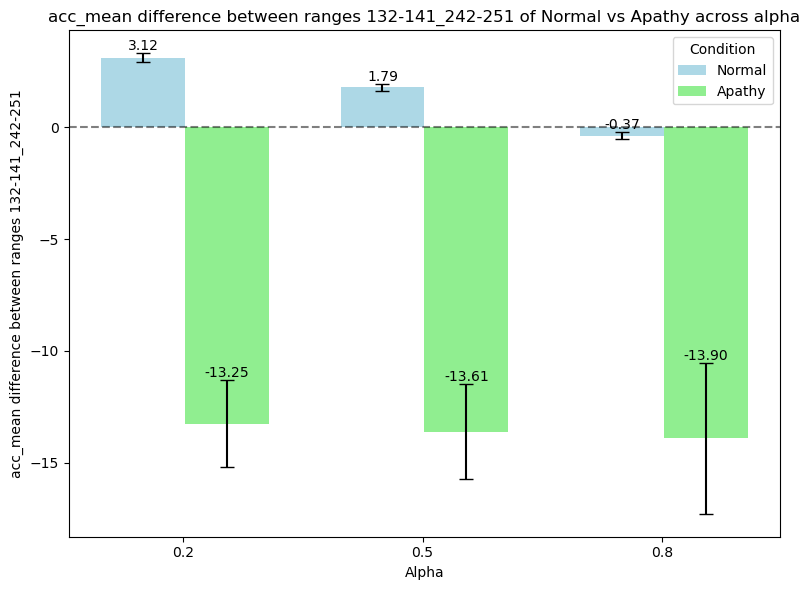

In [7]:
variable = 'acc_mean'
condition_pair = ("Normal", "Apathy")
range_diffs = '132-141_242-251'
plot_variable_diff_histogram(df, variable, condition_pair, range_diffs)

In [62]:
import numpy as np
from scipy import stats

def compare_conditions(df, variable, ranges_str, normal_condition="Normal", other_condition="Delusion", alpha_values=[0.2, 0.5, 0.8]):
    results = {}
    var_name = f"{variable}_diff_{ranges_str}"
    
    for alpha in alpha_values:
        normal_data = df[(df['Condition'] == normal_condition) & (df['AlphaForEpochSup140'] == alpha)][var_name]
        other_data = df[(df['Condition'] == other_condition) & (df['AlphaForEpochSup140'] == alpha)][var_name]
        
        t_stat, p_value = stats.ttest_ind(normal_data, other_data)
        mean_diff = np.mean(normal_data) - np.mean(other_data)
        
        results[alpha] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_difference': mean_diff
        }
    
    return results

def compare_alpha_differences(df, variable, ranges_str, normal_condition="Normal", other_condition="Apathy", alpha_values=[0.2, 0.5, 0.8]):
    results = {}
    var_name = f"{variable}_diff_{ranges_str}"
    
    differences = {}
    for alpha in alpha_values:
        normal_data = df[(df['Condition'] == normal_condition) & (df['AlphaForEpochSup140'] == alpha)][var_name]
        other_data = df[(df['Condition'] == other_condition) & (df['AlphaForEpochSup140'] == alpha)][var_name]
        differences[alpha] = normal_data.values - other_data.values
    
    for i in range(len(alpha_values)):
        for j in range(i+1, len(alpha_values)):
            alpha1, alpha2 = alpha_values[i], alpha_values[j]
            t_stat, p_value = stats.ttest_ind(differences[alpha1], differences[alpha2])
            results[(alpha1, alpha2)] = {
                't_statistic': t_stat,
                'p_value': p_value
            }
    
    return results

def print_formatted_results(condition_stats, alpha_diff_stats, variable, ranges_str):
    print(f"Statistical Analysis Results for {variable}_diff_{ranges_str}")
    print("=" * 80)
    
    print("\n1. Comparison between Normal and Apathy conditions:")
    print("-" * 60)
    for alpha, stats in condition_stats.items():
        print(f"\nAlpha = {alpha}:")
        print(f"  t-statistic: {stats['t_statistic']:.4f}")
        print(f"  p-value: {stats['p_value']:.4e}")
        print(f"  Mean difference: {stats['mean_difference']:.4f}")
        
        # Interpretation
        if stats['p_value'] < 0.001:
            significance = "highly significant"
        elif stats['p_value'] < 0.01:
            significance = "very significant"
        elif stats['p_value'] < 0.05:
            significance = "significant"
        else:
            significance = "not significant"
        
        print(f"  Interpretation: The difference between Normal and Apathy conditions is {significance}.")
        print(f"  On average, the Normal condition is {abs(stats['mean_difference']):.4f} "
              f"{'higher' if stats['mean_difference'] > 0 else 'lower'} than the Apathy condition.")
    
    print("\n2. Comparison of differences across alpha values:")
    print("-" * 60)
    for (alpha1, alpha2), stats in alpha_diff_stats.items():
        print(f"\nComparing Alpha {alpha1} vs Alpha {alpha2}:")
        print(f"  t-statistic: {stats['t_statistic']:.4f}")
        print(f"  p-value: {stats['p_value']:.4f}")
        
        # Interpretation
        if stats['p_value'] < 0.05:
            significance = "statistically significant"
        elif stats['p_value'] < 0.1:
            significance = "marginally significant"
        else:
            significance = "not statistically significant"
        
        print(f"  Interpretation: The difference in effects between Alpha {alpha1} and Alpha {alpha2} is {significance}.")
        if significance != "not statistically significant":
            print(f"  This suggests that the choice of alpha value does affect the observed difference between Normal and Apathy conditions.")
        else:
            print(f"  This suggests that the choice between Alpha {alpha1} and Alpha {alpha2} does not significantly affect the observed difference between Normal and Apathy conditions.")


In [61]:
condition_pair = ("Normal", "Delusion")
variable = 'SilhouetteScore'
ranges_str = '132-141_142-151'
alpha_values = [0.2, 0.5, 0.8]  # Ensure this is a list

condition_stats = compare_conditions(df, variable, ranges_str, alpha_values=alpha_values)
alpha_diff_stats = compare_alpha_differences(df, variable, ranges_str, alpha_values=alpha_values)
print_formatted_results(condition_stats, alpha_diff_stats, variable, ranges_str)

Statistical Analysis Results for SilhouetteScore_diff_132-141_142-151

1. Comparison between Normal and Apathy conditions:
------------------------------------------------------------

Alpha = 0.2:
  t-statistic: 15.2593
  p-value: 4.2486e-15
  Mean difference: 0.0181
  Interpretation: The difference between Normal and Apathy conditions is highly significant.
  On average, the Normal condition is 0.0181 higher than the Apathy condition.

Alpha = 0.5:
  t-statistic: 11.3648
  p-value: 5.3145e-12
  Mean difference: 0.0110
  Interpretation: The difference between Normal and Apathy conditions is highly significant.
  On average, the Normal condition is 0.0110 higher than the Apathy condition.

Alpha = 0.8:
  t-statistic: 6.3222
  p-value: 7.7251e-07
  Mean difference: 0.0026
  Interpretation: The difference between Normal and Apathy conditions is highly significant.
  On average, the Normal condition is 0.0026 higher than the Apathy condition.

2. Comparison of differences across alpha val

In [63]:
def create_statistics_csv(df, variables, ranges_list, alpha_values, output_file='statistics_2.csv'):
    results = []
    
    for variable in variables:
        for ranges_str in ranges_list:
            condition_stats = compare_conditions(df, variable, ranges_str, alpha_values=alpha_values)
            alpha_diff_stats = compare_alpha_differences(df, variable, ranges_str, alpha_values=alpha_values)
            
            for alpha, stats in condition_stats.items():
                results.append({
                    'Variable': variable,
                    'Range': ranges_str,
                    'Comparison': f'Normal vs Delusion (Alpha {alpha})',
                    't_statistic': stats['t_statistic'],
                    'p_value': stats['p_value'],
                    'mean_difference': stats['mean_difference']
                })
            
            for (alpha1, alpha2), stats in alpha_diff_stats.items():
                results.append({
                    'Variable': variable,
                    'Range': ranges_str,
                    'Comparison': f'Alpha {alpha1} vs Alpha {alpha2}',
                    't_statistic': stats['t_statistic'],
                    'p_value': stats['p_value'],
                    'mean_difference': np.nan  # Not applicable for alpha comparisons
                })
    
    # Create DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    print(f"Statistics have been saved to {output_file}")

In [64]:
alpha_values = [0.2, 0.5, 0.8]  # Ensure this is a list
ranges_list = ['132-141_142-151', '132-141_242-251']
variables = ['SilhouetteScore', 'NMI', 'acc_mean', 'SSIM_mean']
create_statistics_csv(df, variables, ranges_list, alpha_values)

Statistics have been saved to statistics_2.csv


In [18]:
def visualize_alpha_trends(df, variables, ranges_list, alpha_values, condition_pair):
    normal_condition, other_condition = condition_pair 
    for variable in variables:
        for ranges_str in ranges_list:
            condition_stats = compare_conditions(df, variable, ranges_str, alpha_values=alpha_values)
            
            # Extract mean differences and prepare for plotting
            alphas = []
            mean_diffs = []
            for alpha, stats in condition_stats.items():
                alphas.append(alpha)
                mean_diffs.append(stats['mean_difference'])
            
            # Create the plot
            plt.figure(figsize=(10, 6))
            plt.plot(alphas, mean_diffs, marker='o')
            plt.title(f'Difference between {normal_condition} and {other_condition} conditions\n{variable}_diff_{ranges_str}')
            plt.xlabel('Alpha value')
            plt.ylabel('Mean difference ({normal_condition} - {other_condition})')
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Add value labels
            for i, txt in enumerate(mean_diffs):
                plt.annotate(f'{txt:.2f}', (alphas[i], mean_diffs[i]), textcoords="offset points", 
                             xytext=(0,10), ha='center')
            
            # Highlight the maximum difference
            max_diff_index = mean_diffs.index(max(mean_diffs))
            plt.scatter(alphas[max_diff_index], mean_diffs[max_diff_index], color='red', s=100, zorder=5)
            plt.annotate(f'Max difference: {mean_diffs[max_diff_index]:.2f}\nAlpha: {alphas[max_diff_index]}', 
                         (alphas[max_diff_index], mean_diffs[max_diff_index]),
                         textcoords="offset points", xytext=(0,-20), ha='center', fontweight='bold')
            
            plt.tight_layout()
            plt.savefig(f"./Plots/Stats/{variable}/Stats_{variable}_diff_{ranges_str}_{normal_condition}_{other_condition}_trend.png")
            plt.close()
            
            print(f"Plot saved as {variable}_diff_{ranges_str}_alpha_trend.png")


In [20]:
variables = ['SilhouetteScore', 'NMI', 'acc_mean', 'SSIM_mean']
ranges_list = ['132-141_242-251', '132-141_142-151']
alpha_values = [0.2, 0.5, 0.8]
condition_pair = ("Normal", "Apathy")
visualize_alpha_trends(df, variables, ranges_list, alpha_values, condition_pair)

Plot saved as SilhouetteScore_diff_132-141_242-251_alpha_trend.png
Plot saved as SilhouetteScore_diff_132-141_142-151_alpha_trend.png
Plot saved as NMI_diff_132-141_242-251_alpha_trend.png
Plot saved as NMI_diff_132-141_142-151_alpha_trend.png
Plot saved as acc_mean_diff_132-141_242-251_alpha_trend.png
Plot saved as acc_mean_diff_132-141_142-151_alpha_trend.png
Plot saved as SSIM_mean_diff_132-141_242-251_alpha_trend.png
Plot saved as SSIM_mean_diff_132-141_142-151_alpha_trend.png


### 6. Digit effect
Not done but maybe exploration

In [ ]:
def analyze_digits_effect(df, variable, condition):
    print(f"\nAnalysis of Digits effect for {variable} in {condition} condition")
    for alpha in alpha_values:
        print(f"  Alpha = {alpha}:")
        subset = df[(df['Condition'] == condition) & (df['AlphaForEpochSup140'] == alpha)]
        for range_val in ranges:
            var = f"{variable}_{range_val}"
            print(f"    {var}:")
            for i, (low1, high1) in enumerate(digit_groups):
                for j, (low2, high2) in enumerate(digit_groups[i+1:], start=i+1):
                    group1 = subset[(subset['Digits'] >= low1) & (subset['Digits'] <= high1)][var]
                    group2 = subset[(subset['Digits'] >= low2) & (subset['Digits'] <= high2)][var]
                    if len(group1) > 0 and len(group2) > 0:
                        p_value, test_name = run_statistical_tests(group1, group2)
                        print(f"      Digits {low1}-{high1} vs {low2}-{high2}: p-value = {p_value:.4f} ({test_name})")
                    else:
                        print(f"      Digits {low1}-{high1} vs {low2}-{high2}: Insufficient data for analysis")


def analyze_digits_effect(df, variable, condition):
    print(f"\nAnalysis of Digits effect for {variable} in {condition} condition")
    for alpha in alpha_values:
        print(f"  Alpha = {alpha}:")
        subset = df[(df['Condition'] == condition) & (df['AlphaForEpochSup140'] == alpha)]
        for digit_group in digit_groups:
            subsets = subset[subset['Digits'] == digit_group]

        for range_val in ranges:
            var = f"{variable}_{range_val}"
            print(f"    {var}:")


def plot_digits_effect(df, variable, condition, range_val):
    plt.figure(figsize=(10, 6))
    var = f"{variable}_{range_val}"
    subset = df[df['Condition'] == condition]
    sns.boxplot(x='Digits', y=var, hue='AlphaForEpochSup140', data=subset)
    plt.title(f"Stats_{var}: Digit Effect in {condition} Condition")
    plt.savefig(f"./Plots/Stats/{variable}/Stats_{var}_{condition}_digits_effect_boxplot.png")
    plt.close()


# To do later because problem in the analysis
condition = "Apathy"
for variable in variables:
        analyze_digits_effect(df, variable, condition)


# To work on the visualization function
for condition in ["Apathy", "Delusion"][0]:
    for variable in variables:
        for range_val in ranges:
            plot_digits_effect(df, variable, condition, range_val)
